# 📑 &nbsp; Deep Learning. P4: Style Recognition
<a href="https://olgabelitskaya.github.io/README.html">&#x1F300; &nbsp; Home Page &nbsp; &nbsp; &nbsp;</a> 
<a href="https://www.instagram.com/olga.belitskaya/">&#x1F300; &nbsp; Instagram Posts &nbsp; &nbsp; &nbsp;</a>
<a href="https://www.pinterest.ru/olga_belitskaya/code-style/">&#x1F300; &nbsp; Pinterest Posts</a><br/>
For this project, I have made the database of photos sorted by products and brands.<br/>
The dataset consists of 2184 color images (150x150x3) with 7 brands and 10 products.<br/>
Original photo files are in the .png format and the labels are integers and string values.<br/>

In [3]:
import urllib,os; from IPython import display
fpath='https://olgabelitskaya.github.io/images/'
lf=['0_0_026.jpeg','1_3_003.jpeg','2_2_039.jpeg',
    '3_5_012.jpeg','4_1_019.jpeg','5_9_005.jpeg','6_8_004.jpeg']
display.HTML("""
<style>
@import url('https://fonts.googleapis.com/css?family=Akronim|Monsieur La Doulaise');
</style>
<table style='width:42%; background-color:silver; color:#FF355E;
              font-family:Monsieur La Doulaise; font-size:250%;'>
<tr style='font-family:Akronim; font-size:80%;'><th><center>Brand</center></th>
<th><center>Image</center></th></tr>
<tr><td><center>Christian Louboutin</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/0_0_026.jpeg' alt='brand0'>
</center></td></tr>
<tr><td><center>Chanel</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/1_3_003.jpeg' alt='brand1'>
</center></td></tr>
<tr><td><center>Dolce & Gabbana</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/2_2_039.jpeg' alt='brand2'>
</center></td></tr>
<tr><td><center>Gucci</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/3_5_012.jpeg' alt='brand3'>
</center></td></tr>
<tr><td><center>Christian Dior</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/4_1_019.jpeg' alt='brand4'>
</center></td></tr>
<tr><td><center>Versace</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/5_9_005.jpeg' alt='brand5'>
</center></td></tr>
<tr><td><center>Yves Saint Laurent</center></td><td><center>
<img width='70' height='70' 
src='https://olgabelitskaya.github.io/images/6_8_004.jpeg' alt='brand6'>
</center></td></tr>
</table>""")

Brand,Image
Christian Louboutin,
Chanel,
Dolce & Gabbana,
Gucci,
Christian Dior,
Versace,
Yves Saint Laurent,


## ✒️&nbsp;Step 0. Importing Libraries and Defining Helpful Functions

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,zipfile
import pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 1.15.2


In [0]:
fw='weights.style.hdf5'
dr2,dr25,dr3,dr5,dr6=\
float(.2),float(.25),float(.3),float(.5),float(.6)
fr,al=float(.5),float(.02)
i0,i1,i2,i3,i4,i5,i7,i8=\
int(0),int(1),int(2),int(3),int(4),int(5),int(7),int(8)
i10,i16,i32,i48,i64,i96=\
int(10),int(16),int(32),int(48),int(64),int(96)
i100,i128,i150,i196,i256=\
int(100),int(128),int(150),int(196),int(256)
i512,i1024=int(512),int(1024)

In [0]:
def ohe(x): 
    return OneHotEncoder(categories='auto')\
           .fit(x.reshape(-i1,i1))\
           .transform(x.reshape(-i1,i1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=float(.2),
                     random_state=i1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def resh(x):
    y=[resize(el,(int(50),int(50),int(3)),
              anti_aliasing=True) for el in x]
    return np.array(y)
def gresh(x): 
    y=np.array([resize(el,(int(125),int(125),int(1)),
                       anti_aliasing=True) for el in x])
    return y.reshape(-int(1),int(125),int(125),int(1))

In [0]:
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#348ABD',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#348ABD',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()
def history_plot2(fit_history):
    keys=list(fit_history.history.keys())[6:]
    pl.figure(figsize=(12,10)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='valid 1')
    pl.plot(fit_history.history[keys[1]],
            color='#37c9e1',label='valid 2')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[2]],
            color='slategray',label='valid 1')
    pl.plot(fit_history.history[keys[3]],
            color='#37c9e1',label='valid 2')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid(); pl.title('Accuracy'); pl.show()

## ✒️&nbsp;Step 1. Loading and Preprocessing the Data

In [9]:
fpath='https://olgabelitskaya.github.io/'
zf='StyleColorImages.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys())
bnames=['Christian Louboutin','Chanel','Dolce & Gabbana','Gucci',
        'Christian Dior','Versace','Yves Saint Laurent']
pnames=['shoes','lipstick','handbag','nail polish','necklace',
        'watches','ring','bracelet','boots','earrings']
fpath2='https://raw.githubusercontent.com/OlgaBelitskaya/'+\
       'deep_learning_projects/master/DL_PP4/'
styles=pd.read_csv(fpath2+'data/style.csv')
styles.tail()

,brand_name,brand_label,product_name,product_label,file
2179,Yves Saint Laurent,6,earrings,9,6_9_017.png
2180,Yves Saint Laurent,6,earrings,9,6_9_018.png
2181,Yves Saint Laurent,6,earrings,9,6_9_019.png
2182,Yves Saint Laurent,6,earrings,9,6_9_020.png
2183,Yves Saint Laurent,6,earrings,9,6_9_021.png


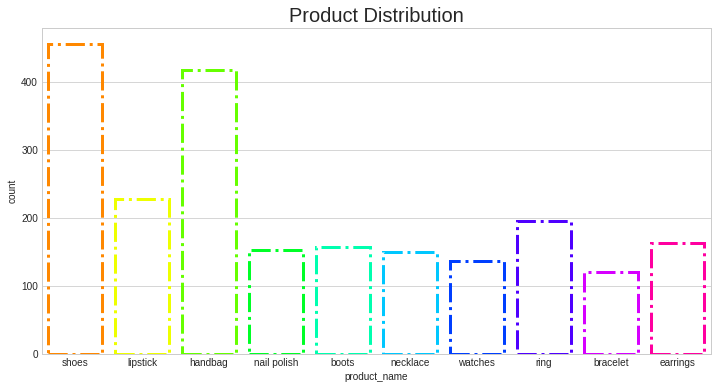

In [10]:
pl.figure(figsize=(12,6))
sn.countplot(x='product_name',data=styles,
             facecolor='none',linewidth=3,linestyle='-.',
             edgecolor=sn.color_palette('hsv',10))
pl.title('Product Distribution',fontsize=20)
pl.show()

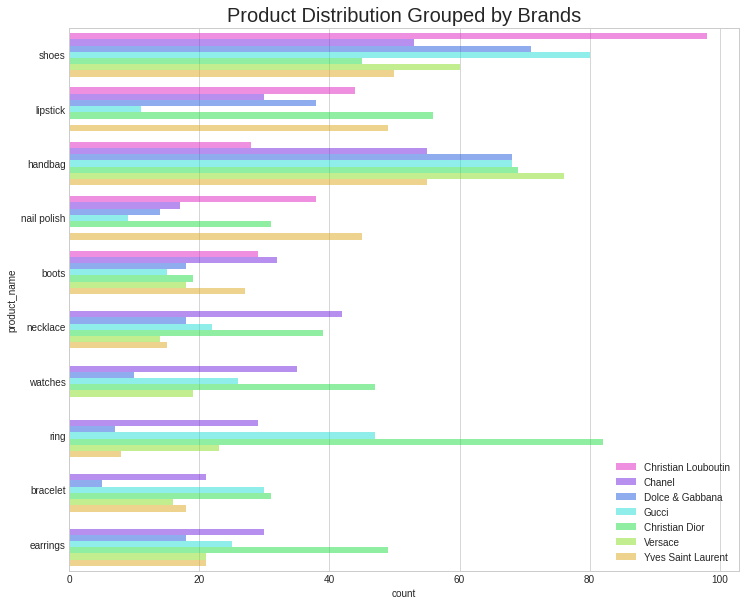

In [11]:
pl.figure(figsize=(12,10))
sn.countplot(y="product_name",hue="brand_name", 
             data=styles,palette='hsv_r',alpha=.5)
ti='Product Distribution Grouped by Brands'
pl.title(ti,fontsize=20)
pl.legend(loc=4); pl.show()

Product:  lipstick
Brand:  Christian Louboutin


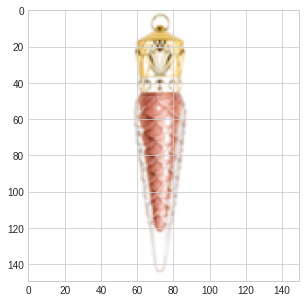

In [12]:
brands=np.array(f[keys[0]])
images=np.array(f[keys[1]])/255
products=np.array(f[keys[2]])
print('Product: ',styles['product_name'][i100])
print('Brand: ',styles['brand_name'][i100])
pl.figure(figsize=(i5,i5)); pl.imshow(images[i100])
pl.show()

Product:  lipstick
Brand:  Christian Louboutin


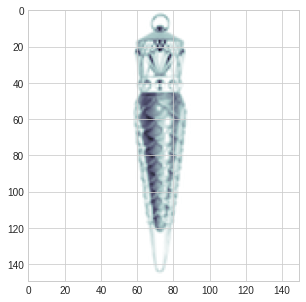

In [13]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
print('Product: ',styles['product_name'][i100])
print('Brand: ',styles['brand_name'][i100])
pl.figure(figsize=(i5,i5))
pl.imshow(gray_images[i100],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [14]:
cbrands,cproducts=ohe(brands),ohe(products)
ctargets=np.concatenate((cbrands,cproducts),axis=1)
simages=resh(images); sgray_images=gresh(gray_images)
pd.DataFrame([simages.shape,sgray_images.shape,
              cbrands.shape,cproducts.shape,
              ctargets.shape])

,0,1,2,3
0,2184,50,50.0,3.0
1,2184,125,125.0,1.0
2,2184,7,NaN,NaN
3,2184,10,NaN,NaN
4,2184,17,NaN,NaN


In [15]:
# Color Images / Brand 
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,cbrands)
# Grayscaled Images / Brand 
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,cbrands)
# Color Images / Product 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cproducts)
# Grayscaled Images / Product 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cproducts)
# Color Images / Multi-Label Target
x_train5,x_valid5,x_test5,\
y_train5,y_valid5,y_test5=tts(images,ctargets)
# Grayscaled Images / Multi-Label Target 
x_train6,x_valid6,x_test6,\
y_train6,y_valid6,y_test6=tts(gray_images,ctargets)
sh=[el.shape for el in \
[x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1,
 x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train5,y_train5,x_valid5,y_valid5,x_test5,y_test5]]
sh2=[el.shape for el in \
[x_train2,y_train2,x_valid2,y_valid2,x_test2,y_test2,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4,
 x_train6,y_train6,x_valid6,y_valid6,x_test6,y_test6]]
pd.DataFrame([sh,sh2]).T

,0,1
0,"(1747, 150, 150, 3)","(1747, 150, 150, 1)"
1,"(1747, 7)","(1747, 7)"
2,"(218, 150, 150, 3)","(218, 150, 150, 1)"
3,"(218, 7)","(218, 7)"
4,"(219, 150, 150, 3)","(219, 150, 150, 1)"
5,"(219, 7)","(219, 7)"
6,"(1747, 150, 150, 3)","(1747, 150, 150, 1)"
7,"(1747, 10)","(1747, 10)"
8,"(218, 150, 150, 3)","(218, 150, 150, 1)"
9,"(218, 10)","(218, 10)"


In [0]:
y_train5_list=[y_train5[:,:i7],y_train5[:,i7:]]
y_test5_list=[y_test5[:,:i7],y_test5[:,i7:]]
y_valid5_list=[y_valid5[:,:i7],y_valid5[:,i7:]]
y_train6_list=[y_train6[:,:i7],y_train6[:,i7:]]
y_test6_list=[y_test6[:,:i7],y_test6[:,i7:]]
y_valid6_list=[y_valid6[:,:i7],y_valid6[:,i7:]]


## ✒️&nbsp;Step 2. One-Label Classification Models

In [16]:
# Color Images / Brands
def model():
    model=Sequential()
    model.add(Conv2D(i32,(i5,i5),padding='same', 
                     input_shape=x_train1.shape[i1:]))
    model.add(LeakyReLU(alpha=al))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr2))
    model.add(Conv2D(i196,(i5,i5)))
    model.add(LeakyReLU(alpha=al))   
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr2))   
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(i512))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(dr5))    
    model.add(Dense(i7))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy', 
                  optimizer='nadam', metrics=['accuracy'])   
    return model
model=model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 196)       156996    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 71, 71, 196)       0         
______________________________________

In [17]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i16,verbose=i2)
history=model.fit(x_train1,y_train1,epochs=i128,batch_size=i128,verbose=i2,
                  validation_data=(x_valid1,y_valid1),
                  callbacks=[checkpointer,lr_reduction,estopping])


Train on 1747 samples, validate on 218 samples
Epoch 1/128
 - 14s - loss: 1.9712 - accuracy: 0.1969 - val_loss: 1.9143 - val_accuracy: 0.2294

Epoch 00001: val_loss improved from inf to 1.91434, saving model to weights.style.hdf5
Epoch 2/128
 - 5s - loss: 1.8846 - accuracy: 0.2187 - val_loss: 1.8771 - val_accuracy: 0.2385

Epoch 00002: val_loss improved from 1.91434 to 1.87714, saving model to weights.style.hdf5
Epoch 3/128
 - 5s - loss: 1.8583 - accuracy: 0.2416 - val_loss: 1.8544 - val_accuracy: 0.2844

Epoch 00003: val_loss improved from 1.87714 to 1.85435, saving model to weights.style.hdf5
Epoch 4/128
 - 5s - loss: 1.8409 - accuracy: 0.2559 - val_loss: 1.8576 - val_accuracy: 0.2752

Epoch 00004: val_loss did not improve from 1.85435
Epoch 5/128
 - 5s - loss: 1.7993 - accuracy: 0.2839 - val_loss: 1.8738 - val_accuracy: 0.2018

Epoch 00005: val_loss did not improve from 1.85435
Epoch 6/128
 - 5s - loss: 1.7992 - accuracy: 0.2793 - val_loss: 1.8349 - val_accuracy: 0.3119

Epoch 0000

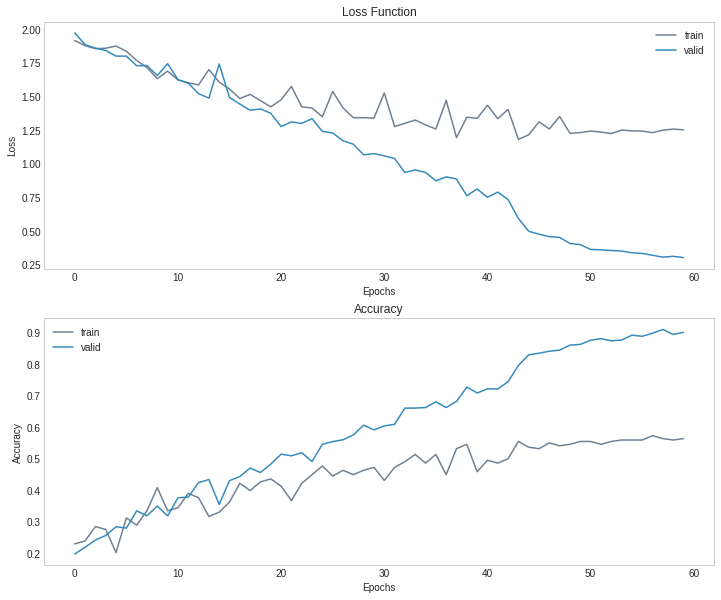

219/219 [==============================] - 1s 2ms/step


[1.234550267049711, 0.5662100315093994]

In [18]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

In [0]:
# Color Images / Products
def model():
    model=Sequential()
    model.add(Conv2D(i32,(i5,i5),padding='same', 
                     input_shape=x_train3.shape[i1:]))
    model.add(LeakyReLU(alpha=al))   
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i196,(i5,i5)))
    model.add(LeakyReLU(alpha=al))   
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))  
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i512))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(dr5))     
    model.add(Dense(i10))
    model.add(Activation('softmax')) 
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
model=model()

In [20]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i16,verbose=i2)
history=model.fit(x_train3,y_train3,epochs=i128,batch_size=i128,verbose=i2,
                  validation_data=(x_valid3,y_valid3),
                  callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/128
 - 5s - loss: 2.2278 - accuracy: 0.1946 - val_loss: 2.1151 - val_accuracy: 0.2248

Epoch 00001: val_loss improved from inf to 2.11511, saving model to weights.style.hdf5
Epoch 2/128
 - 5s - loss: 2.0509 - accuracy: 0.2536 - val_loss: 2.1326 - val_accuracy: 0.2569

Epoch 00002: val_loss did not improve from 2.11511
Epoch 3/128
 - 5s - loss: 1.9211 - accuracy: 0.3039 - val_loss: 1.8948 - val_accuracy: 0.3394

Epoch 00003: val_loss improved from 2.11511 to 1.89482, saving model to weights.style.hdf5
Epoch 4/128
 - 5s - loss: 1.8417 - accuracy: 0.3383 - val_loss: 1.8550 - val_accuracy: 0.4037

Epoch 00004: val_loss improved from 1.89482 to 1.85504, saving model to weights.style.hdf5
Epoch 5/128
 - 5s - loss: 1.7277 - accuracy: 0.3829 - val_loss: 1.7499 - val_accuracy: 0.4128

Epoch 00005: val_loss improved from 1.85504 to 1.74994, saving model to weights.style.hdf5
Epoch 6/128
 - 5s - loss: 1.7240 - accuracy: 0.3560 - val_loss: 1.7

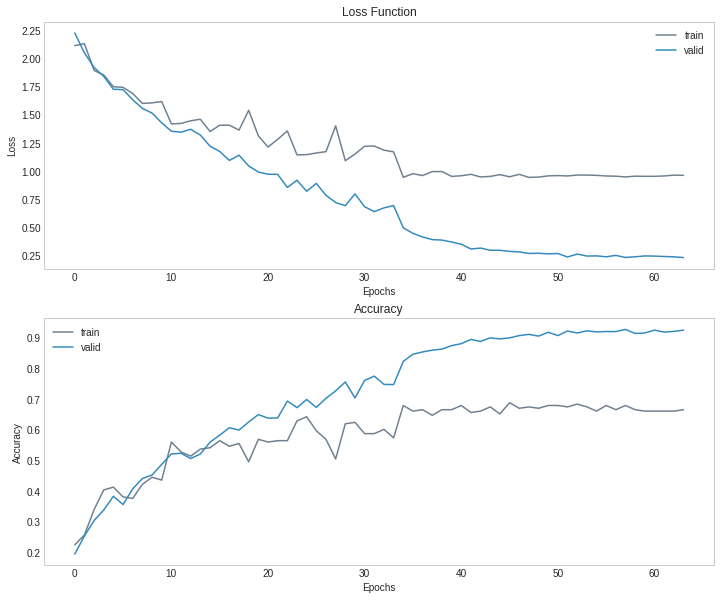

219/219 [==============================] - 0s 1ms/step


[1.0023153791688892, 0.7031963467597961]

In [21]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test3,y_test3)

In [0]:
# Grayscaled Images / Brands 
def gray_model():
    model=Sequential()   
    model.add(Conv2D(i32,(i5,i5),padding='same', 
                     input_shape=x_train2.shape[i1:]))
    model.add(LeakyReLU(alpha=al))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i196,(i5,i5)))
    model.add(LeakyReLU(alpha=al))   
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))  
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i1024))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(dr25))     
    model.add(Dense(i128))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(dr25))    
    model.add(Dense(i7))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])
    return model
gray_model=gray_model()

In [23]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i16,verbose=i2)
history=gray_model.fit(x_train2,y_train2,epochs=i128,batch_size=i128,
                       verbose=i2,validation_data=(x_valid2,y_valid2),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/128
 - 6s - loss: 1.9689 - accuracy: 0.1849 - val_loss: 1.9301 - val_accuracy: 0.2339

Epoch 00001: val_loss improved from inf to 1.93012, saving model to weights.style.hdf5
Epoch 2/128
 - 5s - loss: 1.9261 - accuracy: 0.2141 - val_loss: 1.9207 - val_accuracy: 0.2339

Epoch 00002: val_loss improved from 1.93012 to 1.92066, saving model to weights.style.hdf5
Epoch 3/128
 - 5s - loss: 1.9204 - accuracy: 0.2158 - val_loss: 1.9079 - val_accuracy: 0.2339

Epoch 00003: val_loss improved from 1.92066 to 1.90792, saving model to weights.style.hdf5
Epoch 4/128
 - 5s - loss: 1.8931 - accuracy: 0.2444 - val_loss: 1.8763 - val_accuracy: 0.2661

Epoch 00004: val_loss improved from 1.90792 to 1.87634, saving model to weights.style.hdf5
Epoch 5/128
 - 5s - loss: 1.8763 - accuracy: 0.2599 - val_loss: 1.8662 - val_accuracy: 0.2339

Epoch 00005: val_loss improved from 1.87634 to 1.86617, saving model to weights.style.hdf5
Epoch 6/128
 - 5s - loss: 1

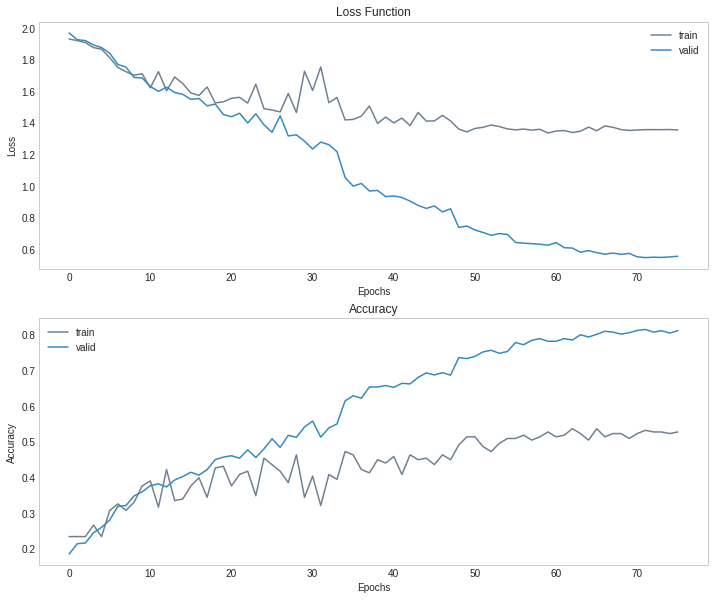

219/219 [==============================] - 0s 1ms/step


[1.4663635187497421, 0.5068492889404297]

In [24]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test2,y_test2)

In [0]:
# Grayscaled Images / Products
def gray_model():
    model=Sequential()   
    model.add(Conv2D(i32,(i5,i5),padding='same', 
                     input_shape=x_train4.shape[i1:]))
    model.add(LeakyReLU(alpha=al)) 
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))
    model.add(Conv2D(i128,(i5,i5)))
    model.add(LeakyReLU(alpha=al))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr25))  
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i1024))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(dr25))    
    model.add(Dense(i128))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(dr25))    
    model.add(Dense(i10))
    model.add(Activation('softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])
    return model
gray_model=gray_model()

In [26]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i16,verbose=i2)
history=gray_model.fit(x_train4,y_train4,epochs=i128,batch_size=i128,verbose=i2,
                       validation_data=(x_valid4,y_valid4),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/128
 - 5s - loss: 2.2249 - accuracy: 0.1923 - val_loss: 2.1383 - val_accuracy: 0.2202

Epoch 00001: val_loss improved from inf to 2.13831, saving model to weights.style.hdf5
Epoch 2/128
 - 3s - loss: 2.0906 - accuracy: 0.2158 - val_loss: 2.0587 - val_accuracy: 0.2615

Epoch 00002: val_loss improved from 2.13831 to 2.05868, saving model to weights.style.hdf5
Epoch 3/128
 - 3s - loss: 1.9964 - accuracy: 0.2610 - val_loss: 2.1350 - val_accuracy: 0.2018

Epoch 00003: val_loss did not improve from 2.05868
Epoch 4/128
 - 3s - loss: 1.9004 - accuracy: 0.2999 - val_loss: 1.8598 - val_accuracy: 0.3991

Epoch 00004: val_loss improved from 2.05868 to 1.85985, saving model to weights.style.hdf5
Epoch 5/128
 - 3s - loss: 1.8710 - accuracy: 0.3234 - val_loss: 1.9226 - val_accuracy: 0.2936

Epoch 00005: val_loss did not improve from 1.85985
Epoch 6/128
 - 3s - loss: 1.8267 - accuracy: 0.3412 - val_loss: 1.8014 - val_accuracy: 0.3761

Epoch 00006:

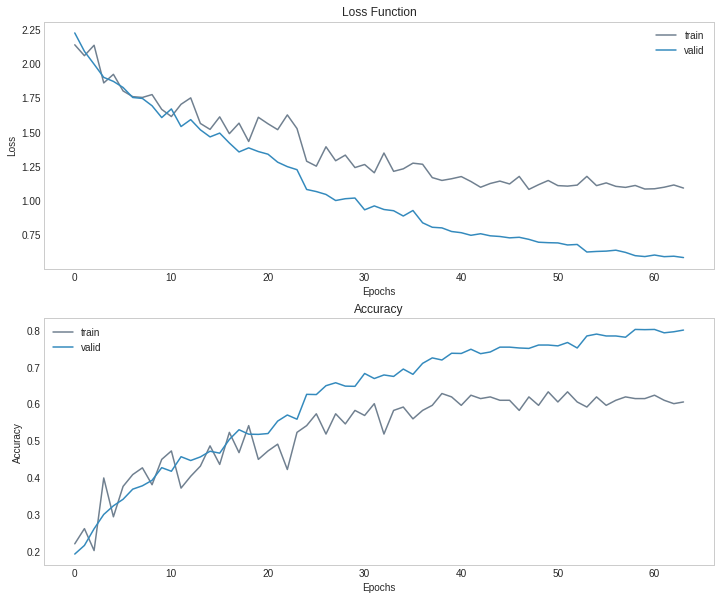

219/219 [==============================] - 0s 1ms/step


[1.0684972288401704, 0.6849315166473389]

In [27]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test4,y_test4)

## ✒️&nbsp;Step 3. Multi-Label Classification Models

In [0]:
# Color Images
def mmodel():    
    model_input=Input(shape=(i150,i150,i3))
    x=BatchNormalization()(model_input)
    x=Conv2D(i32,(i5,i5),padding='same')(model_input)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)   
    x=Conv2D(i196,(i5,i5),padding='same')(x)       
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)              
    x=GlobalMaxPooling2D()(x)   
    x=Dense(i512)(x)
    x=LeakyReLU(alpha=al)(x)    
    x=Dropout(dr25)(x)    
    y1=Dense(i7,activation='softmax')(x)
    y2=Dense(i10,activation='softmax')(x)   
    model=Model(inputs=model_input,outputs=[y1, y2])    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
mmodel=mmodel()

In [29]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i16,verbose=i2)
history=mmodel.fit(x_train5,y_train5_list, 
                   validation_data=(x_valid5,y_valid5_list), 
                   epochs=i128,batch_size=i128,verbose=i2, 
                   callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/128
 - 7s - loss: 4.1399 - dense_12_loss: 1.9286 - dense_13_loss: 2.2078 - dense_12_accuracy: 0.2021 - dense_13_accuracy: 0.1918 - val_loss: 4.0981 - val_dense_12_loss: 1.9120 - val_dense_13_loss: 2.1888 - val_dense_12_accuracy: 0.2339 - val_dense_13_accuracy: 0.1881

Epoch 00001: val_loss improved from inf to 4.09810, saving model to weights.style.hdf5
Epoch 2/128
 - 5s - loss: 4.0278 - dense_12_loss: 1.8885 - dense_13_loss: 2.1389 - dense_12_accuracy: 0.2524 - dense_13_accuracy: 0.2238 - val_loss: 4.0072 - val_dense_12_loss: 1.8813 - val_dense_13_loss: 2.1272 - val_dense_12_accuracy: 0.2339 - val_dense_13_accuracy: 0.2569

Epoch 00002: val_loss improved from 4.09810 to 4.00715, saving model to weights.style.hdf5
Epoch 3/128
 - 5s - loss: 3.8489 - dense_12_loss: 1.8260 - dense_13_loss: 2.0180 - dense_12_accuracy: 0.2667 - dense_13_accuracy: 0.2627 - val_loss: 3.8158 - val_dense_12_loss: 1.8071 - val_dense_13_loss: 2.0121 - val_den

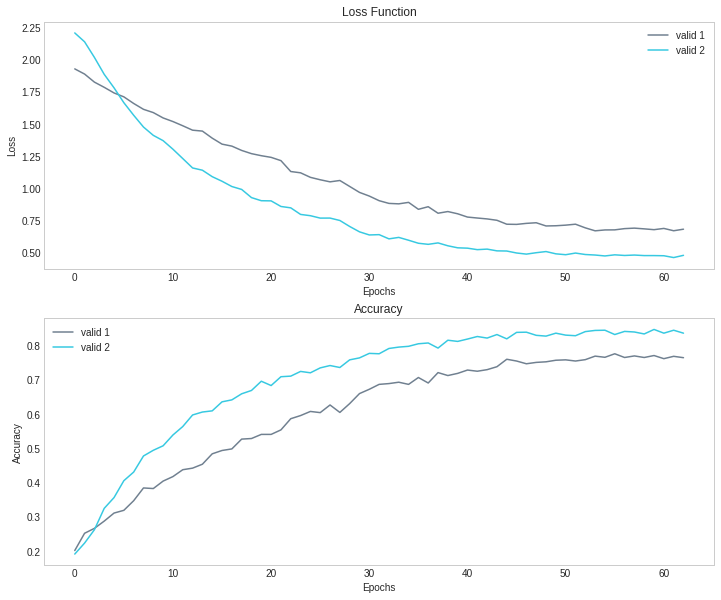

219/219 [==============================] - 0s 2ms/step
Scores: 
 [2.263760878070849, 1.2960823774337769, 0.9670835137367249, 0.543379008769989, 0.6849315166473389]
The Brand Label. Accuracy: 54.34%
The Product Label. Accuracy: 68.49%


In [30]:
history_plot2(history)
mmodel.load_weights(fw)
scores=mmodel.evaluate(x_test5,y_test5_list)
print("Scores: \n",(scores))
print("The Brand Label. Accuracy: %.2f%%"%(scores[i3]*i100))
print("The Product Label. Accuracy: %.2f%%"%(scores[i4]*i100))

In [0]:
# Grayscaled Images
def gray_mmodel():    
    model_input=Input(shape=(i150,i150,i1))
    x=BatchNormalization()(model_input)
    x=Conv2D(i32,(i5,i5),padding='same')(model_input)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)    
    x=Conv2D(i256,(i5,i5),padding='same')(x)
    x=LeakyReLU(alpha=al)(x)       
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr25)(x)             
    x=GlobalMaxPooling2D()(x)    
    x=Dense(i1024)(x)
    x=LeakyReLU(alpha=al)(x)   
    x=Dropout(dr25)(x)   
    x=Dense(i256)(x)
    x=LeakyReLU(alpha=al)(x)    
    x=Dropout(dr25)(x)    
    y1=Dense(i7,activation='softmax')(x)
    y2=Dense(i10,activation='softmax')(x)       
    model=Model(inputs=model_input,outputs=[y1,y2])
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])   
    return model
gray_mmodel=gray_mmodel()

In [32]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i16,verbose=i2)
history=gray_mmodel.fit(x_train6,y_train6_list, 
                        validation_data=(x_valid6,y_valid6_list), 
                        epochs=i128,batch_size=i128,verbose=i2, 
                        callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/128
 - 9s - loss: 4.1399 - dense_16_loss: 1.9463 - dense_17_loss: 2.1935 - dense_16_accuracy: 0.1940 - dense_17_accuracy: 0.1969 - val_loss: 4.1022 - val_dense_16_loss: 1.9288 - val_dense_17_loss: 2.1774 - val_dense_16_accuracy: 0.2523 - val_dense_17_accuracy: 0.2202

Epoch 00001: val_loss improved from inf to 4.10218, saving model to weights.style.hdf5
Epoch 2/128
 - 6s - loss: 4.0280 - dense_16_loss: 1.9348 - dense_17_loss: 2.0945 - dense_16_accuracy: 0.2089 - dense_17_accuracy: 0.2198 - val_loss: 4.0636 - val_dense_16_loss: 1.9042 - val_dense_17_loss: 2.1615 - val_dense_16_accuracy: 0.2339 - val_dense_17_accuracy: 0.2936

Epoch 00002: val_loss improved from 4.10218 to 4.06360, saving model to weights.style.hdf5
Epoch 3/128
 - 6s - loss: 3.8929 - dense_16_loss: 1.8914 - dense_17_loss: 1.9979 - dense_16_accuracy: 0.2404 - dense_17_accuracy: 0.2650 - val_loss: 3.8538 - val_dense_16_loss: 1.8877 - val_dense_17_loss: 1.9744 - val_den

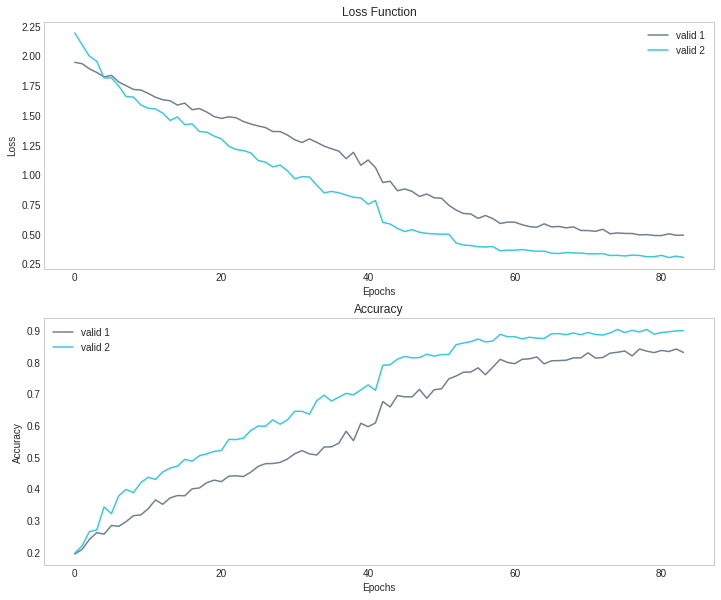

219/219 [==============================] - 1s 3ms/step
Scores: 
 [2.1987907940938594, 1.2418677806854248, 0.9506549835205078, 0.5890411138534546, 0.698630154132843]
The Brand Label. Accuracy: 58.90%
The Product Label. Accuracy: 69.86%


In [33]:
history_plot2(history)
gray_mmodel.load_weights(fw)
scores=gray_mmodel.evaluate(x_test6,y_test6_list)
print("Scores: \n",(scores))
print("The Brand Label. Accuracy: %.2f%%"%(scores[i3]*i100))
print("The Product Label. Accuracy: %.2f%%"%(scores[i4]*i100))

## ✒️ &nbsp; Step 4. Keras Applications

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50pi
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3pi
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xceptionpi
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 \
import preprocess_input as inceptionresnetv2pi
def resh(x):
    y=[resize(el,(224,224,3),
              anti_aliasing=True) for el in x]
    return np.array(y).astype('float32')

In [0]:
resize_x_train1=resh(x_train1)
resize_x_valid1=resh(x_valid1)
resize_x_test1=resh(x_test1)
resnet50_base_model=ResNet50(weights='imagenet',include_top=False)
pvx_train1=resnet50_base_model.predict(resize_x_train1)
pvx_valid1=resnet50_base_model.predict(resize_x_valid1)
pvx_test1=resnet50_base_model.predict(resize_x_test1)

In [0]:
sh=pvx_train1.shape[1:]
def resnet50_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))        
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))
    model.add(Dense(7,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
resnet50_model=resnet50_model()

In [48]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=\
resnet50_model.fit(pvx_train1,y_train1,
                   validation_data=(pvx_valid1,y_valid1),
                   epochs=200,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping]);

Train on 1747 samples, validate on 218 samples
Epoch 1/200
 - 1s - loss: 2.0131 - accuracy: 0.1826 - val_loss: 1.9203 - val_accuracy: 0.2339

Epoch 00001: val_loss improved from inf to 1.92034, saving model to weights.style.hdf5
Epoch 2/200
 - 1s - loss: 1.9522 - accuracy: 0.1866 - val_loss: 1.9098 - val_accuracy: 0.2339

Epoch 00002: val_loss improved from 1.92034 to 1.90975, saving model to weights.style.hdf5
Epoch 3/200
 - 1s - loss: 1.9355 - accuracy: 0.1986 - val_loss: 1.9135 - val_accuracy: 0.2339

Epoch 00003: val_loss did not improve from 1.90975
Epoch 4/200
 - 1s - loss: 1.9316 - accuracy: 0.2044 - val_loss: 1.9087 - val_accuracy: 0.2339

Epoch 00004: val_loss improved from 1.90975 to 1.90869, saving model to weights.style.hdf5
Epoch 5/200
 - 1s - loss: 1.9264 - accuracy: 0.2078 - val_loss: 1.9044 - val_accuracy: 0.2294

Epoch 00005: val_loss improved from 1.90869 to 1.90439, saving model to weights.style.hdf5
Epoch 6/200
 - 1s - loss: 1.9192 - accuracy: 0.2015 - val_loss: 1.9

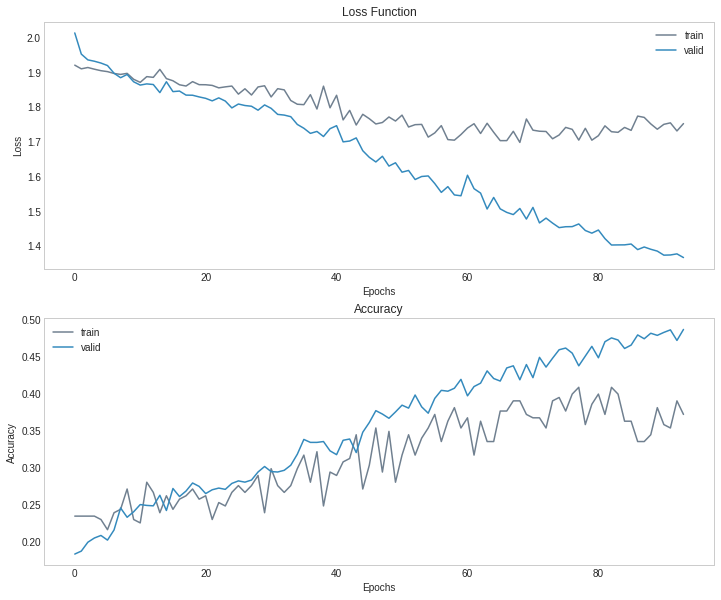

219/219 [==============================] - 0s 303us/step
Accuracy: 40.64%


[1.572545089678133, 0.4063926935195923]

In [49]:
history_plot(history)
resnet50_model.load_weights(fw)
resnet50_scores=resnet50_model.evaluate(pvx_test1,y_test1)
print("Accuracy: %.2f%%"%(resnet50_scores[1]*100))
resnet50_scores